# Anwendung und Vergleich von Machine Learning und Deep Learning Algorithmen zur Vorhersage von COVID-19 Kennzahlen

## Neuronale Netze
Lorem ipsum dolor sit amet, consetetur sadipscing elitr, sed diam nonumy eirmod tempor invidunt ut labore et dolore magna aliquyam erat, sed diam voluptua. At vero eos et accusam et justo duo dolores et ea rebum. Stet clita kasd gubergren, no sea takimata sanctus est Lorem ipsum dolor sit amet. Lorem ipsum dolor sit amet, consetetur sadipscing elitr, sed diam nonumy eirmod tempor invidunt ut labore et dolore magna aliquyam erat, sed diam voluptua. At vero eos et accusam et justo duo dolores et ea rebum. Stet clita kasd gubergren, no sea takimata sanctus est Lorem ipsum dolor sit amet.

## Imports

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, Flatten, MaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from matplotlib import pyplot

%matplotlib inline

## Laden der Daten

In [44]:
# Load the data from disk
# X_train = np.load('../preprocessing/X_train.npy')
# X_test = np.load('../preprocessing/X_test.npy')
# y_train = np.load('../preprocessing/y_train.npy')
# y_test = np.load('../preprocessing/y_test.npy')

data = np.load('../preprocessing/dataset.npy')

In [90]:
# Move first columns (= cases) to the end of the array
permutations = [1,2,3,4,5,6,7,8,9,10,0]
data = data[:, permutations]

In [93]:
# Function to transform data into sequences
def transform_to_sequences(data, n_in=1, n_out=1, dropnan=True):
	# n_vars corresponds to the number of features
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	
	# input sequence (t-n, ..., t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
		
	# forecast sequence(t, t+1, ..., t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
		
	# put all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	
	if dropnan:
		# drop all rows that contains Nan values (1st row)
		agg.dropna(inplace=True)
	return agg

In [94]:
# Split data in training and test set
num_datapoints = data.shape[0]
num_training = int(num_datapoints*0.7)

train, test = data[:num_training], data[num_training:]

# Verify the shapes of train and test
print(train.shape)
print(test.shape)

(462, 11)
(199, 11)


In [167]:
# Scale the datasets using RobutScaler (as this scaler scales the data according to the quantile range (default: Inter Quartile Range IQR))
# TODO: select good scaler
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.fit_transform(test)

In [181]:
# Transform the data into sequences
train_transformed = transform_to_sequences(train_scaled, 14, 1)
test_transformed = transform_to_sequences(test_scaled, 14, 1)

In [182]:
# Verify the shapes of train_transformed and test_transformed
print(train_transformed.shape)
print(test_transformed.shape)

(448, 165)
(185, 165)


In [183]:
# Split data in input X and output y
n_input_timestamps = 14
n_features_per_timestamp = 11
n_input_features = n_input_timestamps * n_features_per_timestamp

In [184]:
X_train, y_train = train_transformed.values[:, :n_input_features], train_transformed.values[:, n_input_features:]
print(X_train.shape)
print(y_train.shape)

(448, 154)
(448, 11)


In [185]:
pd.DataFrame(y_train).head()

,0,1,2,3,4,5,6,7,8,9,10
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.272483,0.115409,0.000000,0.018068
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.299731,0.126950,0.018519,0.019874
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.326979,0.138491,0.027778,0.031571
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.354228,0.150032,0.037037,0.033853
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.381476,0.161573,0.027778,0.040890


In [186]:
# Drop columns 0 to 9 as we just want to predict feature #10 (= cases)
y_train = y_train[:, -1]

In [187]:
X_test, y_test = test_transformed.values[:, :n_input_features], test_transformed.values[:, n_input_features:]
print(X_test.shape)
print(y_test.shape)

(185, 154)
(185, 11)


In [188]:
pd.DataFrame(y_test).head()

,0,1,2,3,4,5,6,7,8,9,10
0,0.867587,0.000014,0.733161,0.474988,1.000000,0.000371,0.435694,0.248276,0.133835,0.00000,0.021300
1,0.850201,0.000000,0.859001,0.599870,0.311022,0.000604,0.592891,0.241379,0.129780,0.03125,0.013778
2,0.806728,0.000000,0.884554,0.493402,0.183680,0.000868,0.490748,0.206897,0.122248,0.12500,0.010452
3,0.805378,0.000000,0.939504,0.270029,0.202176,0.001949,0.263427,0.203448,0.103708,0.09375,0.007760
4,0.755921,0.000000,0.929662,1.000000,0.247540,0.002303,1.000000,0.200000,0.095017,0.09375,0.007126


In [189]:
# Drop columns 0 to 9 as we just want to predict feature #10 (= cases)
y_test = y_test[:, -1]

In [190]:
# Reshape data to fit into the LSTM model (dimension must be [samples, time steps, features])
X_train_lstm = X_train.reshape((X_train.shape[0], n_input_timestamps, n_features_per_timestamp))
y_train_lstm = y_train.reshape((y_train.shape[0], 1))

X_test_lstm = X_test.reshape((X_test.shape[0], n_input_timestamps, n_features_per_timestamp))
y_test_lstm = y_test.reshape((y_test.shape[0], 1))

In [203]:
# Reshape data to fit into CNN model (dimension must be [samples, time steps, features])
X_train_cnn = X_train.reshape((X_train.shape[0], n_input_timestamps, n_features_per_timestamp))
y_train_cnn = y_train.reshape((y_train.shape[0], 1))

X_test_cnn = X_test.reshape((X_test.shape[0], n_input_timestamps, n_features_per_timestamp))
y_test_cnn = y_test.reshape((y_test.shape[0], 1))

## Modelle

### Convolutional Neuronal Network (CNN)

In [212]:
# Implementation is based on https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/
def create_cnn_model():
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2])))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2])))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam')

    return model

In [213]:
model_cnn = create_cnn_model()
model_cnn.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 13, 64)            1472      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 6, 64)            0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 5, 64)             8256      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 2, 64)            0         
 1D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 128)               0         
                                                                 
 dense_18 (Dense)            (None, 50)              

### Recurrent Neural Network (mit LSTM)

In [199]:
# Implementation is based on https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
def create_lstm_model():
    model = Sequential()
    model.add(LSTM(100, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
    model.add(Dense(1, activation='relu'))

    model.compile(loss='mean_squared_error', optimizer='adam')

    return model

In [200]:
model_lstm = create_lstm_model()
model_lstm.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 100)               44800     
                                                                 
 dense_13 (Dense)            (None, 1)                 101       
                                                                 
Total params: 44,901
Trainable params: 44,901
Non-trainable params: 0
_________________________________________________________________


## Training der Modelle

### Training des CNN 

In [214]:
# Train CNN model
history_cnn = model_cnn.fit(X_train_cnn, y_train_cnn, epochs=300, batch_size=32, shuffle=False)

Epoch 1/300
14/14 [==============================] - 0s 2ms/step - loss: 0.0522
Epoch 2/300
14/14 [==============================] - 0s 2ms/step - loss: 0.0190
Epoch 3/300
14/14 [==============================] - 0s 3ms/step - loss: 0.0163
Epoch 4/300
14/14 [==============================] - 0s 2ms/step - loss: 0.0110
Epoch 5/300
14/14 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 6/300
14/14 [==============================] - 0s 2ms/step - loss: 0.0083
Epoch 7/300
14/14 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 8/300
14/14 [==============================] - 0s 3ms/step - loss: 0.0098
Epoch 9/300
14/14 [==============================] - 0s 3ms/step - loss: 0.0072
Epoch 10/300
14/14 [==============================] - 0s 2ms/step - loss: 0.0066
Epoch 11/300
14/14 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 12/300
14/14 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 13/300
14/14 [=================

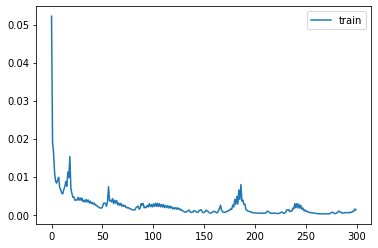

In [215]:
# Plot history
pyplot.plot(history_cnn.history['loss'], label='train')
pyplot.legend()
pyplot.show()

### Training des LSTM

In [195]:
# Train LSTM model
history_lstm = model_lstm.fit(X_train_lstm, y_train_lstm, epochs=300, batch_size=32, shuffle=False)

Epoch 1/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0029
Epoch 2/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0032
Epoch 3/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0042
Epoch 4/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0023
Epoch 5/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0024
Epoch 6/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 7/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 8/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0029
Epoch 9/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 10/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0024
Epoch 11/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0028
Epoch 12/300
14/14 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 13/300
14/14 [=================

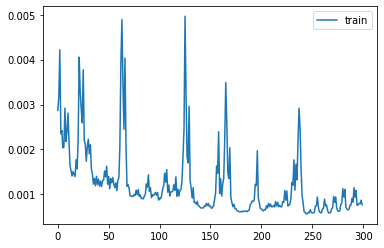

In [197]:
# Plot history
pyplot.plot(history_lstm.history['loss'], label='train')
pyplot.legend()
pyplot.show()

## Evaluation